<h1>ADAM home</h1>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import numpy as np
import tensorflow as tf # changed to intel-optimized build
tf.random.set_seed(42)
np.random.seed(42)
import gc
import time
import random
from winsound import Beep
from PIL import Image
import pickle

def beep():
    Beep(1000, 100)

beep()

In [4]:
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
beep()

In [6]:
addr = r"C:\Users\mchen\Desktop\ml\chapter6\env"
os.chdir(addr)


In [7]:

# os.chdir(addr)
# with open('useful_e_data.pkl', 'rb') as f:
#     [train_x, val_x, test_x, train_y, val_y, test_y] = pickle.load(f)

#     # reshape data
# train_x = train_x.reshape(np.shape(train_x)[0], np.shape(train_x)[1], np.shape(train_x)[2], 1)
# val_x = val_x.reshape(np.shape(val_x)[0], np.shape(val_x)[1], np.shape(val_x)[2], 1)
# test_x = test_x.reshape(np.shape(test_x)[0], np.shape(test_x)[1], np.shape(test_x)[2], 1)

# train_y = tf.one_hot(train_y.astype(np.int32), depth=10)
# val_y = tf.one_hot(val_y.astype(np.int32), depth=10)
# test_y = tf.one_hot(test_y.astype(np.int32), depth=10)




# beep()

In [8]:
# f_data = [train_x, val_x, test_x, train_y, val_y, test_y]
# with open('f_data.pkl', 'wb') as f:
#     pickle.dump(f_data, f)

In [11]:
with open('f_data.pkl', 'rb') as f:
    [train_x, val_x, test_x, train_, val_y, test_y] = pickle.load(f)
    
beep()

In [10]:
# sample training data
n = len(train_x)
sn = int(n / 10)
np.random.seed(42)
index = np.random.choice([i for i in range(n)], size=sn, replace=False)

sub_tx, sub_ty = [], []

for ind in index:
    sub_tx.append(train_x[ind])
    sub_ty.append(train_y[ind])

sub_tx = np.array(sub_tx)
sub_ty = np.array(sub_ty)
sub_tx = sub_tx.reshape(np.shape(sub_tx)[0], np.shape(sub_tx)[1], np.shape(sub_tx)[2], 1)

beep()

In [12]:

def train_cnn_adam_2( # using default ADAM params
        lmbda,
        batch_size,
        n_eph,
        train_x,
        train_y,
        val_x,
        val_y,
        test_x,
        test_y,
        addr
    ):
    ################################################################
    #   relu CNN network as described in chapter 6
    ################################################################
    tf.random.set_seed(42)
    ################################################################
    print('lmbda= {}\n'.format(lmbda))
    print('n_eph= {}\n'.format(n_eph))
    print('batch_size= {}\n'.format(batch_size))
    ################################################################
    ################################################################
    # construct netwoek model
    input_shape = (28, 28, 1)
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Conv2D( # no padding
            20,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda),
            input_shape=input_shape))
    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Conv2D( # no padding
            40,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))
    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    
    

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
            1000,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.Dense(
            100,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))
    
    model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))
    ################################################################

    
    
    
    
    ################################################################
    # optimizer: ADAM
    optimizer_adam = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name='Adam'
    )
    ################################################################
    # compile model
    model.compile(
        optimizer=optimizer_adam,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    ################################################################
    model.summary()
    ################################################################
    # save the model when val_acc is best
    stamp = str(time.time()).replace('.', '_')
    print('\n\n\ntime stamp:', stamp + '\n\n\n')
    checkpoint_filepath = addr + '\{}'.format(stamp)
    print('checkpoint_filepath:',checkpoint_filepath)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    ################################################################
    ################################################################
    #    train model  
    ts = time.time()
    history = model.fit(
        train_x, train_y, 
        epochs=n_eph,
        batch_size=batch_size,
        validation_data=(val_x, val_y),
        callbacks=[model_checkpoint_callback],
        shuffle=True
    )
    te = time.time()

    print('total time:', te - ts)
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    ################################################################
    ################################################################
    #    load the weights for the best epoch (best val accuracy)
    model.load_weights(checkpoint_filepath)
    ################################################################
    ################################################################
    #    evaluate test data at the best epoch
    [test_data_loss, test_data_accuracy] = model.evaluate(
        test_x, test_y,
        batch_size=len(test_x)
    )
    beep()
    print('acc', acc)
    print('loss', loss)
    print('val_acc', val_acc)
    print('val_loss', val_loss)
    ################################################################
    plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
    plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
    plt.title('CNN relu, expanded train data, ADAM, lmbda={}, {} epochs'.format(lmbda, n_eph)) 
    plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
    plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
    plt.legend()
    plt.show()
    print('acc', acc)
    print('loss', loss)
    print('val_acc', val_acc)
    print('val_loss', val_loss)

beep()

lmbda= 0.0001

n_eph= 128

batch_size= 10

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 20)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 40)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 640)               0         
                                                                 
 dense_3 (D

75000/75000 [==============================] - 661s 9ms/step - loss: 0.0441 - accuracy: 0.9930 - val_loss: 0.0558 - val_accuracy: 0.9922
Epoch 44/128
75000/75000 [==============================] - 667s 9ms/step - loss: 0.0437 - accuracy: 0.9931 - val_loss: 0.0547 - val_accuracy: 0.9913
Epoch 45/128
75000/75000 [==============================] - 667s 9ms/step - loss: 0.0438 - accuracy: 0.9931 - val_loss: 0.0559 - val_accuracy: 0.9918
Epoch 46/128
75000/75000 [==============================] - 659s 9ms/step - loss: 0.0436 - accuracy: 0.9931 - val_loss: 0.0803 - val_accuracy: 0.9856
Epoch 47/128
75000/75000 [==============================] - 669s 9ms/step - loss: 0.0438 - accuracy: 0.9929 - val_loss: 0.0552 - val_accuracy: 0.9909
Epoch 48/128
75000/75000 [==============================] - 666s 9ms/step - loss: 0.0437 - accuracy: 0.9930 - val_loss: 0.0598 - val_accuracy: 0.9914
Epoch 49/128
75000/75000 [==============================] - 674s 9ms/step - loss: 0.0439 - accuracy: 0.9931 - val

75000/75000 [==============================] - 639s 9ms/step - loss: 0.0426 - accuracy: 0.9932 - val_loss: 0.0597 - val_accuracy: 0.9905
Epoch 98/128
75000/75000 [==============================] - 642s 9ms/step - loss: 0.0428 - accuracy: 0.9931 - val_loss: 0.0591 - val_accuracy: 0.9901
Epoch 99/128
75000/75000 [==============================] - 639s 9ms/step - loss: 0.0427 - accuracy: 0.9932 - val_loss: 0.0534 - val_accuracy: 0.9920
Epoch 100/128
75000/75000 [==============================] - 643s 9ms/step - loss: 0.0432 - accuracy: 0.9932 - val_loss: 0.0612 - val_accuracy: 0.9912
Epoch 101/128
75000/75000 [==============================] - 641s 9ms/step - loss: 0.0429 - accuracy: 0.9932 - val_loss: 0.0622 - val_accuracy: 0.9889
Epoch 102/128
75000/75000 [==============================] - 640s 9ms/step - loss: 0.0432 - accuracy: 0.9932 - val_loss: 0.0561 - val_accuracy: 0.9915
Epoch 103/128
75000/75000 [==============================] - 643s 9ms/step - loss: 0.0426 - accuracy: 0.9932 -

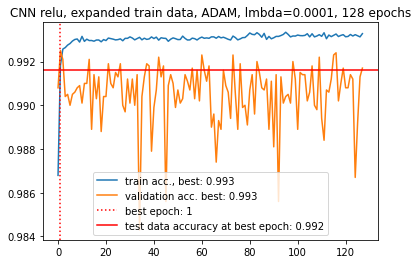

acc [0.986794650554657, 0.9918293356895447, 0.9925706386566162, 0.9926373362541199, 0.9927520155906677, 0.9928240180015564, 0.9929373264312744, 0.9930093288421631, 0.9930319786071777, 0.9928906559944153, 0.9931506514549255, 0.9929226636886597, 0.9930226802825928, 0.9929599761962891, 0.992962658405304, 0.9929306507110596, 0.9929839968681335, 0.9929853081703186, 0.9929026961326599, 0.9930040240287781, 0.9929599761962891, 0.9930746555328369, 0.9930506944656372, 0.9930239915847778, 0.9929893612861633, 0.9930026531219482, 0.9930386543273926, 0.9929506778717041, 0.9930613040924072, 0.9930613040924072, 0.9931280016899109, 0.9930760264396667, 0.9929919838905334, 0.9930506944656372, 0.9931079745292664, 0.9929933547973633, 0.9930679798126221, 0.993013322353363, 0.9930346608161926, 0.9931266903877258, 0.9930520057678223, 0.9931173324584961, 0.9929786920547485, 0.9930880069732666, 0.993065357208252, 0.9930586814880371, 0.9929266571998596, 0.9930226802825928, 0.9930813312530518, 0.9930466413497925,

In [14]:
lmbda = 0.1 / 10 / 10 / 10
batch_size = 10
n_eph = 128

# addr = r"C:\Users\mchen\Desktop\ml\chapter6\env"

a = train_cnn_adam_2( # using default ADAM params
    lmbda,
    batch_size,
    n_eph,
    train_x,
    train_y,
#     sub_tx,
#     sub_ty,
    val_x,
    val_y,
    test_x,
    test_y,
    addr
)

del a
gc.collect()

beep()